References:
    * https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec# 

## Load

In [1]:
import json

In [2]:
raw_data = json.load(open('example.dialog.json', 'r'))['rasa_nlu_data']['common_examples']

In [3]:
import pandas as pd

In [4]:
data = pd.DataFrame(raw_data)

In [5]:
%matplotlib inline

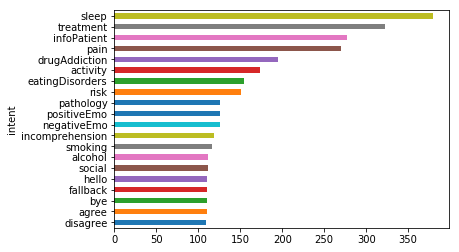

In [6]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

## Preprocess

### Tokenize the text

In [7]:
import nltk, re

In [8]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [9]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(data)

### Clean the text

In [10]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    #stopwords = nltk.corpus.stopwords.words('english')
    
    with open('long-stop-en.txt', 'r') as f:
        stopwords = list(map(lambda x: x.strip(), f.readlines()))

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(data)

In [11]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(data)

In [12]:
from gensim.corpora import Dictionary

In [13]:
dictionary = Dictionary(documents=data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 1880 words.


In [14]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(data)

In [15]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

### Plot

In [16]:
from collections import Counter

In [17]:
import numpy as np

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

In [19]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [20]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

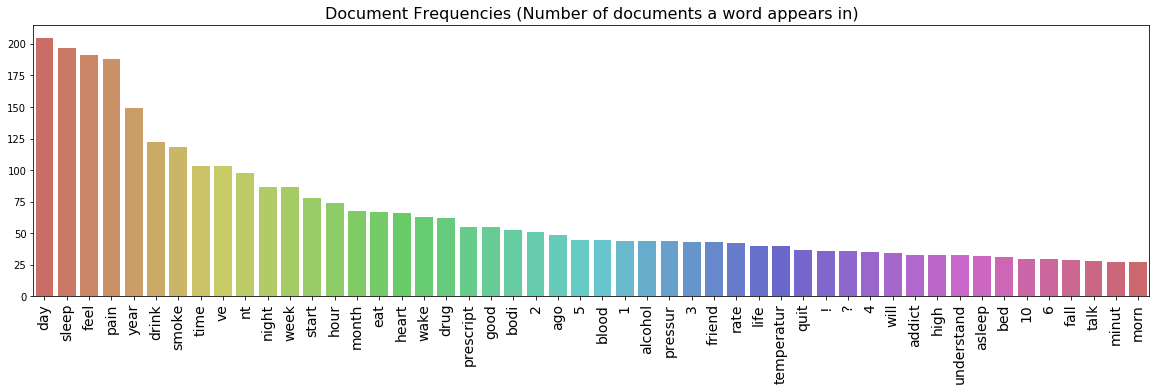

In [21]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

## W2V features

In [18]:
sentences = []
for sentence_group in data.stemmed_text:
    sentences.extend([sentence_group])

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))

Number of sentences: 3307.
Number of texts: 3307.


In [19]:
sentences

[['drink', 'bottl', 'wine', 'day', 'week'],
 ['drink', 'ounc', 'vodka', 'averag', 'day'],
 ['month', 'year', 'drink'],
 ['stage', 'alcohol', 'addict'],
 ['buy', 'pack', 'night', 'work'],
 ['drink'],
 ['25', 'year', 've', 'battl', 'alcohol', '5', 'year'],
 ['don', 't', 'drink', 'drink', 'don', 't', 'limit'],
 ['weekend', 'window', 'drink'],
 ['2', 'month', 'clean'],
 ['appar', 'inabl', 'drink', 'sensibl'],
 ['final', '28', 'day', 'rehab', 'stint'],
 ['concern', 'drink', 'regular', 'basi'],
 ['drink', 'morn'],
 ['start', 'huf', 'alcohol'],
 ['drink', 'issu', 'year'],
 ['alcohol', 'drink'],
 ['well', 'cycl', 'drink'],
 ['honestli', 'drink', 'escap', 'demon'],
 ['ve', 'worri', 'drink'],
 ['help', 'reducingstop', 'heavi', 'alcohol', 'consumpt'],
 ['drink', 'vodka', '1st', '2nd', '3rd'],
 ['drink', 'can', 'half', 'bottl', 'wine', 'week', 'even'],
 ['drink', 'ounc', 'vodka', 'averag', 'day'],
 ['ve', 'problem', 'alcohol', '12'],
 ['alcohol', 'drink'],
 ['sinclair', 'method'],
 ['ve', 'misus',

In [20]:
from gensim.models import Word2Vec

In [21]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [120]:
W2Vmodel.wv.vocab.keys()

dict_keys(['drink', 'bottl', 'wine', 'day', 'week', 'ounc', 'vodka', 'averag', 'month', 'year', 'stage', 'alcohol', 'addict', 'buy', 'pack', 'night', 'work', '25', 've', '5', 'don', 't', 'limit', 'weekend', 'window', '2', 'clean', 'inabl', 'final', '28', 'rehab', 'concern', 'regular', 'basi', 'morn', 'start', 'issu', 'well', 'cycl', 'worri', 'help', 'heavi', '1st', '3rd', 'half', 'even', 'problem', '12', 'method', 'ten', 'real', 'time', 'drank', '13', 'whiskey', '30', 'minut', 'watch', 'eat', 'calori', 'food', 'will', '10', 'yr', 'reli', 'dont', 'feel', 'fine', 'leav', 'drunk', 'point', 'unit', '4', 'pretti', '1', 'white', '33', 'full', 'age', '15', 'kill', 'urg', 'nt', 'eleven', 'left', 'reduc', 'thought', 'slow', 'cut', 'bad', 'ive', '3', 'manag', 'love', 'tuesday', 'drinker', 'straight', 'liter', 'go', 'easili', 'mood', 'mid', '40', 'life', 'today', 'lot', 'weigh', '120', 'abus', 'lax', 'massiv', 'habit', 'normal', 'hard', 'keep', 'fat', 'bing', '6', 'accept', 'entir', 'asham', 'bla

In [22]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    try:
        words = sentence_group  # words in text
    except:
        print(sentence_group)
        words = np.concatenate([['']])  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.text))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [160]:
np.vstack([W2Vmodel['hello'], W2Vmodel['pain']]).shape

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(2, 200)

In [23]:
def get_w2v_features_by_word(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    try:
        words = sentence_group  # words in text
    except:
        print(sentence_group)
        words = np.concatenate([['']])  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = None
    
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            if featureVec is not None:
                featureVec = np.vstack([featureVec, W2Vmodel[word]])
            else:
                featureVec = W2Vmodel[word].reshape(1, w2v_model.vector_size)
        else:
            if featureVec is not None:
                featureVec = np.vstack([featureVec, 
                                       np.zeros(w2v_model.vector_size, dtype="float32")\
                                        .reshape(1, w2v_model.vector_size)])
            else:
                featureVec = np.zeros(w2v_model.vector_size, dtype="float32")\
                .reshape(1, w2v_model.vector_size)

    if featureVec is None:
        featureVec = np.zeros(w2v_model.vector_size, dtype="float32").reshape(1, w2v_model.vector_size)
    return featureVec

In [152]:
torch.from_numpy(get_w2v_features_by_word(W2Vmodel, data.stemmed_text[71]))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0

In [172]:
data.stemmed_text[5]

['drink']

In [147]:
W2Vmodel[]

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word '' not in vocabulary"

In [24]:
X_w2v = np.array(list(map(np.array, data.w2v_features)))

## Pretrained embeddings

In [27]:
import gensim.downloader as api

In [28]:
info = api.info()

In [29]:
model = api.load("glove-twitter-25")

In [ ]:
model = api.load("word2vec-google-news-300")

### test

In [31]:
model.most_similar("sleep")

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wake', 0.9654639959335327),
 ('tired', 0.9245999455451965),
 ('feel', 0.9237402081489563),
 ('awake', 0.9227220416069031),
 ('sleeping', 0.9174003601074219),
 ('alone', 0.9170509576797485),
 ('too', 0.9083741307258606),
 ('asleep', 0.9069899320602417),
 ('sigh', 0.9062435030937195),
 ('ill', 0.9025631546974182)]

In [32]:
data['glove_features'] = list(map(lambda sen_group:
                                      get_w2v_features(model, sen_group),
                                      data.text))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', 
                                                        binary=True) 

In [ ]:
model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

## LDA features

In [25]:
from gensim.models import LdaModel, LdaMulticore

In [26]:
corpus = data.bow

In [27]:
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [28]:
LDAmodel.top_topics(corpus=corpus)[0]

([(0.21004091, 'blood'),
  (0.20550151, 'pressur'),
  (0.06427919, 'high'),
  (0.06266532, 'stay'),
  (0.06053597, 'work'),
  (0.055638112, 'awak'),
  (0.04226912, 'thing'),
  (0.03545266, 'three'),
  (0.033185445, 've'),
  (0.030840684, '2'),
  (0.028081752, 'week'),
  (0.023215065, '19'),
  (0.0147382105, 'sleep'),
  (0.014235693, 'happen'),
  (0.009609614, 'averag'),
  (0.009548596, 'varieti'),
  (0.009545308, '160100'),
  (0.009522491, 'drop'),
  (0.0048507643, 'half'),
  (0.0048507643, '11674')],
 -12.943069409417957)

In [29]:
def document_to_lda_features(lda_model, document):
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

In [ ]:
LDAmodel.num_topics

In [30]:
def document_to_lda_features_by_word(lda_model, dictionary, document):
    if len(document)==0:
        return np.zeros(lda_model.num_topics, dtype="float32").reshape(1, lda_model.num_topics)
    featureVec = np.array(LDAmodel.get_document_topics(
        dictionary.doc2bow([document[0]]), minimum_probability=0))[:,1].reshape(1, lda_model.num_topics)
    for word in document[1:]:
        featureVec = np.vstack([featureVec,
                                np.array(LDAmodel.get_document_topics(
                                    dictionary.doc2bow([word]), minimum_probability=0))[:,1]])
    return featureVec

In [34]:
document_to_lda_features_by_word(LDAmodel, dictionary, data.stemmed_text[5]).shape

(1, 150)

In [104]:
np.array(LDAmodel.get_document_topics(dictionary.doc2bow(data.stemmed_text[0]), minimum_probability=0))[:,1]

array([0.00518984, 0.00479808, 0.00446131, 0.00416872, 0.00391214,
       0.00368532, 0.00348335, 0.00330237, 0.00313927, 0.00299153,
       0.00285706, 0.00273416, 0.0026214 , 0.00251757, 0.00242166,
       0.00233278, 0.0022502 , 0.00217326, 0.00210141, 0.00203416,
       0.16897923, 0.00191179, 0.00185597, 0.00180332, 0.00175357,
       0.00170649, 0.00166187, 0.00161953, 0.00157929, 0.001541  ,
       0.00150452, 0.00146973, 0.00143652, 0.00140477, 0.0013744 ,
       0.00134531, 0.00131742, 0.11411247, 0.00126499, 0.0012403 ,
       0.00121656, 0.00119372, 0.00117171, 0.0011505 , 0.00113005,
       0.00111031, 0.00109125, 0.00107283, 0.00105502, 0.00103779,
       0.00102112, 0.00100498, 0.00098934, 0.00097417, 0.00095947,
       0.0009452 , 0.00093135, 0.0009179 , 0.00090483, 0.00089213,
       0.00087979, 0.00086777, 0.00085609, 0.00084471, 0.00083363,
       0.00082284, 0.00081232, 0.00080207, 0.00079208, 0.00078233,
       0.00077282, 0.00076353, 0.00075447, 0.00074562, 0.00073

In [36]:
dictionary.doc2bow([data.stemmed_text[0][0]])

[(2, 1)]

In [31]:
X_lda = np.array(list(map(np.array, data.lda_features)))

## NN

In [32]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## CNN

- use convolutional network, where Each iput word is represented by concatenation of LDA, Word2Vec vectors  and position information


In [33]:
X_combined = np.append(X_lda, X_w2v, axis=1)

In [34]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, size, hidden_size, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Conv1d(size, hidden_size, 1)
        self.w_2 = nn.Conv1d(hidden_size, size, 1)
        self.layer_norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1,2)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1,2)
        output = self.dropout(output)
        output = self.layer_norm(output+residual)
        return output

In [72]:
ff = PositionwiseFeedForward(X_combined.shape[1], 32)

In [69]:
optim = torch.optim.Adam(ff.parameters(), lr=0.001)

In [67]:
vX = torch.FloatTensor(np.expand_dims(X_combined, axis=1))

In [70]:
vX.size()

torch.Size([3307, 1, 350])

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

0.9680489897727966
0.9640774726867676
0.9601070284843445
0.9561769366264343
0.9522504806518555
0.948356032371521
0.9444425106048584
0.9405285716056824
0.9366381168365479
0.9326656460762024
0.9288002252578735
0.9248769879341125
0.9209607243537903
0.9170325398445129
0.9131657481193542
0.9091456532478333
0.9052810072898865
0.9013986587524414
0.8973845839500427
0.893551230430603
0.8895586729049683
0.8856364488601685
0.8817161917686462
0.8777768611907959
0.8738114237785339
0.8699252605438232
0.8659960627555847
0.8621287941932678
0.8582482933998108
0.8543862700462341
0.8504664897918701
0.8466577529907227
0.8427897095680237
0.8389542698860168
0.8351725339889526
0.831360936164856
0.8275992274284363
0.8238689303398132
0.820135772228241
0.8164650797843933
0.8128035664558411
0.8091684579849243
0.8056170344352722
0.8020508289337158
0.7985145449638367
0.7950485348701477
0.7915606498718262
0.7881027460098267
0.7846823334693909
0.7812260985374451
0.7778424024581909
0.7744419574737549
0.77109527587890

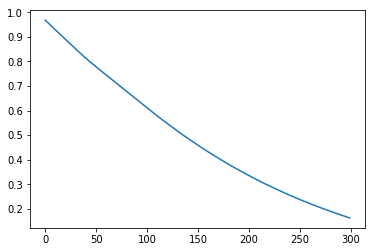

In [40]:
losses = []
for epoch in range(300):
    optim.zero_grad()
    haty = ff(vX)
    loss = F.mse_loss(haty, vX)
    loss.backward()
    print(loss.data.item())
    losses.append(loss.data.item())
    optim.step()
plt.plot(losses)

In [73]:
haty = ff(vX)

In [74]:
haty.size()

torch.Size([3307, 1, 350])

In [46]:
haty.view(3307,150)

tensor([[ 0.8846,  0.1376,  0.1269,  ...,  0.0456,  1.1224, -1.1323],
        [ 0.1361,  1.1095,  5.5634,  ..., -0.0802,  1.1913, -0.9712],
        [ 0.7933,  0.1828,  0.2083,  ..., -0.0059,  1.2815, -1.0642],
        ...,
        [ 0.6602,  0.9614,  0.1026,  ..., -0.0082,  1.0829, -1.2267],
        [ 0.7720,  1.0582,  0.1316,  ..., -0.0779,  1.1442, -1.0118],
        [ 0.6581,  0.9554,  0.1076,  ..., -0.0018,  1.0754, -1.2048]],
       grad_fn=<ViewBackward>)

In [197]:
haty[0], vX[0]

(tensor([[-0.0757, -0.1207, -0.0455, -0.0497, -0.0256,  0.0132,  0.0680,  0.0327,
           0.0222, -0.0022, -0.0651, -0.0389,  0.0800,  0.0698,  0.0470,  0.0601,
           0.0555, -0.0079,  0.0274, -0.0397, -0.0305, -0.3278,  0.0256, -0.0214,
           0.0478,  0.0046, -0.0936,  0.1607,  0.0557,  0.0531,  0.0016, -0.0195,
           0.0215, -0.0634,  0.0078, -0.1689, -0.0245, -0.0114,  0.0548, -0.0909,
          -0.0672, -0.0170, -0.0677, -0.1054, -0.0991,  0.0158,  0.1246,  0.3459,
           0.0268, -0.1106, -0.0274, -0.0329,  0.0261, -0.0963, -0.0163,  0.2559,
           0.4575,  0.8376,  0.0539, -0.1411, -0.2452,  0.1016,  0.0437,  0.0756,
          -0.0897,  0.0131, -0.0869, -0.0378,  0.2269, -0.1105,  1.2845, -3.9065,
          -0.0851,  0.0014,  0.0315,  0.0108, -0.0237, -0.0199, -0.0265,  0.0206,
          -0.1041, -0.0929,  0.0314, -0.0519, -0.0261,  0.0675,  0.0083, -0.1363,
          -0.0366, -0.0487, -0.0205, -0.0864,  0.0118,  0.0649,  0.0323, -0.0476,
          -0.072

In [76]:
X_cnn = haty.view(X_combined.shape[0],X_combined.shape[1]).detach().numpy()

## BiLSTSM by sentence

In [184]:
from torchnlp.text_encoders import WhitespaceEncoder

In [185]:
encoder = WhitespaceEncoder(list(data['text'].values))

In [186]:
encoder.encode('i drink six ounces of vodka average per day')

tensor([17, 18, 19, 20, 11, 21, 22, 23, 13])

In [41]:
class BiLSTMS(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, dropout=0.5):
        super(BiLSTMS, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.dropout = dropout
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=True)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(2, self.batch_size, self.hidden_dim)))

    def forward(self, sentence):
        x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        return lstm_out

In [193]:
bi = BiLSTMS(16, 124, encoder.vocab_size, batch_size=1)

In [194]:
bi(X_encoded[0])

tensor([[[ 0.0488,  0.1043, -0.0211,  ...,  0.0211,  0.0845,  0.1311]],

        [[-0.0253,  0.0406,  0.0341,  ..., -0.0088,  0.0836,  0.0565]],

        [[-0.0801,  0.0077,  0.0555,  ..., -0.0069,  0.0836,  0.0469]],

        ...,

        [[-0.1944, -0.0426,  0.0751,  ...,  0.0141,  0.0728, -0.0079]],

        [[-0.1763, -0.0638,  0.0769,  ...,  0.0044,  0.0568,  0.0278]],

        [[-0.2241, -0.0452,  0.0486,  ...,  0.0098,  0.0363, -0.0196]]],
       grad_fn=<CatBackward>)

In [265]:
X_encoded[:2]

tensor([[   5,   17,   17,  ...,   33,   17,   33],
        [   6,   18,   24,  ...,   14,  160,   14]])

In [262]:
bi(encoder.encode('i drink six of vodka average per day'))[-1]

tensor([[-0.0325,  0.0855,  0.0454,  0.0074,  0.0676,  0.0378,  0.0732, -0.0656,
         -0.0156, -0.0355,  0.0530,  0.1031, -0.1181,  0.0765,  0.0231, -0.0804,
          0.0831,  0.0369,  0.0590, -0.0130, -0.0892, -0.0225,  0.0671, -0.1069,
         -0.0665, -0.0837,  0.0363,  0.0769, -0.0546, -0.0454,  0.1450, -0.0284,
         -0.1608,  0.0393,  0.0365,  0.0465, -0.1083,  0.1504,  0.0141, -0.1403,
          0.0395,  0.0301,  0.0361,  0.0916,  0.0443,  0.0097,  0.0467, -0.0501,
         -0.0472,  0.1427, -0.0667,  0.0588,  0.0877, -0.0864, -0.1150, -0.0339,
          0.1332, -0.1505, -0.0964,  0.0104,  0.1071, -0.0822, -0.0058,  0.0751,
         -0.0316, -0.1330, -0.0179, -0.0419, -0.1654,  0.0322,  0.0751, -0.0086,
         -0.0029,  0.0839, -0.0961, -0.0247,  0.0972, -0.0568, -0.0353,  0.0492,
         -0.0681,  0.1462, -0.0429,  0.0162,  0.2085,  0.0671,  0.0159, -0.1534,
         -0.0817,  0.0115,  0.0537, -0.0895, -0.1098, -0.0538, -0.0931, -0.1418,
         -0.0717,  0.0192,  

In [187]:
X_encoded = nn.utils.rnn.pad_sequence(list(map(lambda x: encoder.encode(x), data['text'].values)))

In [56]:
X_bilstm = list(map(lambda x: bi(x), X_encoded))

## BiLSTM by word

In [35]:
X_w2v_encoded = nn.utils.rnn.pad_sequence(list(map(lambda x: 
                                                   torch.FloatTensor(get_w2v_features_by_word(W2Vmodel, x)), 
                                                   data['stemmed_text'].values)))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [36]:
X_lda_encoded = nn.utils.rnn.pad_sequence(list(map(lambda x: 
                                                   torch.from_numpy(
                                                       document_to_lda_features_by_word(LDAmodel, dictionary, x)).float(), 
                                                   data['stemmed_text'].values)))

In [37]:
X_w2v_encoded.size(), X_lda_encoded.size()

(torch.Size([12, 3307, 200]), torch.Size([12, 3307, 150]))

In [59]:
data.stemmed_text.apply(len).mean()

2.743574236468098

In [39]:
X_lda_w2v_encoded = torch.cat((X_lda_encoded, X_w2v_encoded), 2)

In [162]:
X_lda_w2v_encoded

tensor([[[ 0.0156,  0.0144,  0.0134,  ...,  0.0248, -0.0017,  0.0044],
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0248, -0.0017,  0.0044],
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0207, -0.0032,  0.0057],
         ...,
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0027, -0.0020,  0.0033],
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0231, -0.0011,  0.0066],
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0027, -0.0020,  0.0033]],

        [[ 0.0156,  0.0144,  0.0134,  ...,  0.0167, -0.0028,  0.0042],
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0051,  0.0014, -0.0011],
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0323, -0.0069,  0.0101],
         ...,
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0231, -0.0011,  0.0066],
         [ 0.0156,  0.0144,  0.5134,  ...,  0.0073, -0.0011, -0.0012],
         [ 0.0156,  0.0144,  0.0134,  ...,  0.0231, -0.0011,  0.0066]],

        [[ 0.0156,  0.0144,  0.0134,  ...,  0.0183, -0.0027,  0.0026],
         [ 0.0156,  0.0144,  0.0134,  ...,  0

In [84]:
class BiLSTM_for_emb(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, batch_size, dropout=0.5):
        super(BiLSTM_for_emb, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=True)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(2, self.batch_size, self.hidden_dim)))

    def forward(self, sentence):
        x = sentence
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        return lstm_out

In [88]:
emb_bi = BiLSTM_for_emb(350, 100, 1)#X_lda_w2v_encoded.size(1))

In [86]:
X_bilstm = emb_bi(X_lda_w2v_encoded).detach().numpy()

In [87]:
X_bilstm.shape

(12, 3307, 200)

compute cosine dist for represantations

## Dataset

In [29]:
X_lda = np.array(list(map(np.array, data.lda_features)))
X_w2v = np.array(list(map(np.array, data.w2v_features)))

In [ ]:
X_glove = np.array(list(map(np.array, data.glove_features)))
#X_combined = np.append(
X_combined = np.append(X_lda, X_w2v, axis=1)
#, X_glove, axis=1)

In [ ]:
X_train_combined.shape

## Clustering

In [44]:
K = len(data['intent'].unique())

In [92]:
X = X_lda
y = data['intent']

---

In [46]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [47]:
from sklearn.mixture import GaussianMixture

In [95]:
km = KMeans(K).fit(X)

In [94]:
km = AgglomerativeClustering(K).fit(X)

In [317]:
km = GaussianMixture(K, tol=1e-6, max_iter=500).fit(X)

---

In [78]:
comp = pd.DataFrame(data[['text', 'intent']])

In [79]:
comp['clusters'] = km.predict(X)

In [52]:
comp['clusters'] = km.labels_

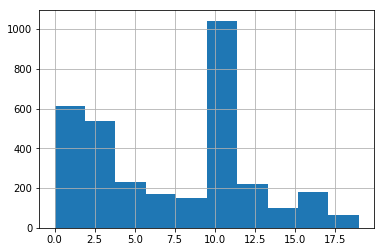

In [80]:
comp['clusters'].hist()

In [81]:
pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
            .style.background_gradient(axis=1)

In [55]:
from sklearn.metrics import *

In [70]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [82]:
(
    purity_score(comp['intent'], comp['clusters']),
    silhouette_score(X, comp['clusters']),
    homogeneity_score(comp['intent'], comp['clusters']),
    completeness_score(comp['intent'], comp['clusters']),
)

(0.24584215300876927, 0.3361177, 0.1654319840371526, 0.1836995173580649)

In [350]:
np.mean([


0.044,
0.071,
0.079


])

0.06466666666666666

In [83]:
np.mean([
    purity_score(comp['intent'], comp['clusters']),
    silhouette_score(X, comp['clusters']),
    homogeneity_score(comp['intent'], comp['clusters']),
    completeness_score(comp['intent'], comp['clusters']),
])

0.2327728422618663

In [ ]:
comp[comp['clusters']==0]['text'].unique()

## Quick easy classifier

- 10 fold cross validation on 100 examples from labelled data
- Feed forward network
- Input = sequence of word representations

In [96]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def balanced_sample_maker(X, y, sample_size, random_seed=42):
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('Good all classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    return data_train,labels_train

number of sampled example  2000 number of sample per class  100  #classes:  20
number of classes  20
True
Good all classes have the same number of examples


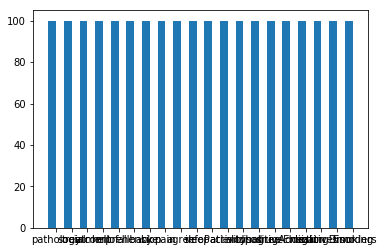

In [97]:
X_train,y_train=balanced_sample_maker(X,y,100)

In [98]:
bad_df = y.index.isin(y_train.index)
X_test = pd.DataFrame(X)[~bad_df]
y_test = data[~bad_df]['intent']

In [99]:
X_test.shape

(1859, 150)

In [100]:
from sklearn.svm import SVC

In [101]:
clf = SVC(kernel='linear', C=1, random_state=0).fit(X_train, y_train)

In [102]:
clf.score(X_test, y_test)

0.3431952662721893

In [103]:
clf.predict(X_test[:40])

array(['risk', 'sleep', 'alcohol', 'alcohol', 'drugAddiction',
       'treatment', 'alcohol', 'smoking', 'activity', 'risk', 'treatment',
       'risk', 'alcohol', 'treatment', 'risk', 'risk', 'risk', 'disagree',
       'alcohol', 'risk', 'risk', 'risk', 'alcohol', 'incomprehension',
       'treatment', 'social', 'treatment', 'bye', 'alcohol', 'alcohol',
       'infoPatient', 'eatingDisorders', 'eatingDisorders', 'treatment',
       'alcohol', 'hello', 'treatment', 'hello', 'pain',
       'incomprehension'], dtype=object)

In [104]:
from sklearn.model_selection import cross_val_score

In [105]:
cv_scores = cross_val_score(clf, X_test, y_test, cv=10) 

In [106]:
cv_scores

array([0.39690722, 0.39378238, 0.33854167, 0.42105263, 0.42553191,
       0.38502674, 0.36065574, 0.41436464, 0.36363636, 0.34857143])

In [107]:
print('{:2.3} + {:2.3}%'.format(np.mean(cv_scores), np.std(cv_scores)))

0.385 + 0.0293%


In [298]:
from sklearn.metrics import confusion_matrix

In [361]:
clf_res = pd.DataFrame([clf.predict(X_test), y_test]).T
clf_res.columns = ['class', 'intent']

In [362]:
cm = pd.DataFrame(confusion_matrix(clf_res['intent'], clf_res['class']), 
             index=clf.classes_, columns=clf.classes_)

In [363]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=1)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,50,7,5,0,4,0,0,15,6,0,0,0,0,0,0,4,0,0,1,6
agree,3,7,1,0,18,0,0,8,4,3,0,0,0,0,1,0,0,0,0,1
alcohol,4,4,15,0,1,1,0,7,0,3,1,0,0,0,0,14,0,0,0,1
bye,1,4,0,4,15,0,0,17,1,1,0,0,0,0,0,3,0,0,0,0
disagree,0,6,0,0,18,0,0,9,0,7,0,0,0,0,0,0,0,0,0,3
drugAddiction,12,6,5,0,11,1,0,13,5,7,0,0,4,3,1,32,0,5,2,10
eatingDisorders,10,3,6,1,3,2,16,4,4,6,0,0,1,0,4,15,0,2,0,2
fallback,2,4,1,0,15,0,0,13,1,0,0,0,0,0,1,1,0,0,0,0
hello,5,8,0,0,8,0,0,11,7,4,0,0,0,0,0,4,0,0,0,1
incomprehension,6,5,0,2,4,0,0,5,3,19,0,0,0,0,0,0,0,0,1,1


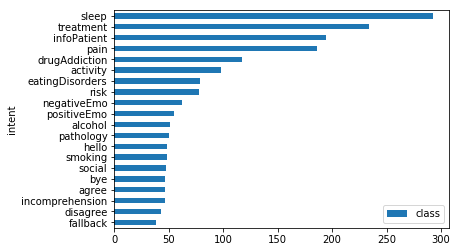

In [158]:
clf_res.groupby('intent').count().sort_values('class').plot(kind='barh')

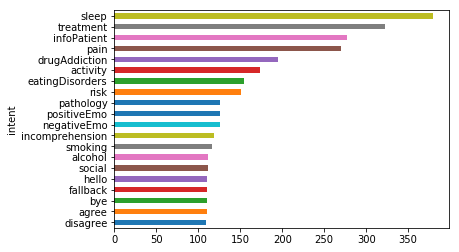

In [155]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

In [71]:
data.loc[0]

entities             [{'start': 34, 'end': 38, 'value': 'wine', 'en...
intent                                                         alcohol
text                 i’m drinking at least a bottle of wine a day i...
tokenized_text       [i, m, drinking, at, least, a, bottle, of, win...
stopwords_removed                  [drinking, bottle, wine, day, week]
lemmatized_text                    [drinking, bottle, wine, day, week]
stemmed_text                           [drink, bottl, wine, day, week]
bow                           [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
w2v_features         [0.0005263121, 0.00016797545, -0.0003662128, 0...
lda_features         [0.005189838353544474, 0.004798077046871185, 0...
Name: 0, dtype: object

## Label new data

In [108]:
import json

In [142]:
new_data = list(map(lambda x: x['post'], json.loads(open('subset.json', 'r').read())))

In [143]:
new_data = sum(list(map(lambda x: x.split('\n'), new_data)), [])

In [144]:
new_data = sum(list(map(lambda x: x.split('.'), new_data)), [])

In [145]:
new_data = list(map(lambda x: x.strip(), new_data))

In [146]:
new_data = list(filter(lambda x: len(x)>0, new_data))

In [147]:
new_dt = pd.DataFrame(new_data, columns=['text'])

In [148]:
lda_preprocessing(new_dt)

In [149]:
new_dt['stem_len'] = new_dt.stemmed_text.apply(len)

In [152]:
new_dt[(new_dt['stem_len']>0)&(new_dt['stem_len']<=10)]

,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,stem_len
0,how about a divorce support group for those wh...,"[how, about, a, divorce, support, group, for, ...","[divorce, support, group, process, divorced, n...","[divorce, support, group, process, divorced, n...","[divorc, support, group, process, divorc, nt, ...","[(104, 1), (234, 1), (1121, 1), (1249, 1), (13...",7
1,i know when i was divorced 6 years ago after 2...,"[i, know, when, i, was, divorced, 6, years, ag...","[divorced, 6, years, ago, 23, years, marriage,...","[divorced, 6, year, ago, 23, year, marriage, g...","[divorc, 6, year, ago, 23, year, marriag, god,...","[(9, 2), (155, 1), (178, 1), (194, 1), (1356, 1)]",9
2,anyone have any other comments?,"[anyone, have, any, other, comments, ?]","[comments, ?]","[comment, ?]","[comment, ?]","[(966, 1), (1809, 1)]",2
3,i'm welcoming all suggestions and comments,"[i, m, welcoming, all, suggestions, and, comme...","[welcoming, suggestions, comments]","[welcoming, suggestion, comment]","[welcom, suggest, comment]","[(1809, 1)]",3
4,i just need some sound advice,"[i, just, need, some, sound, advice]","[sound, advice]","[sound, advice]","[sound, advic]","[(1374, 1)]",2
5,i have a dd who is 2,"[i, have, a, dd, who, is, 2]","[dd, 2]","[dd, 2]","[dd, 2]","[(26, 1)]",2
6,"she is very smart, tall for her age, speaks in...","[she, is, very, smart, tall, for, her, age, sp...","[smart, tall, age, speaks, complete, sentences]","[smart, tall, age, speaks, complete, sentence]","[smart, tall, age, speak, complet, sentenc]","[(98, 1), (353, 1), (863, 1), (991, 1)]",6
7,she appears to be 3 instead of just turning 2,"[she, appears, to, be, 3, instead, of, just, t...","[appears, 3, turning, 2]","[appears, 3, turning, 2]","[appear, 3, turn, 2]","[(26, 1), (114, 1), (531, 1), (918, 1)]",4
8,she goes to daycare full-time,"[she, goes, to, daycare, fulltime]","[daycare, fulltime]","[daycare, fulltime]","[daycar, fulltim]",[],2
9,it's an in-home daycare with only one other ch...,"[it, s, an, inhome, daycare, with, only, one, ...","[inhome, daycare, child]","[inhome, daycare, child]","[inhom, daycar, child]","[(444, 1)]",3


In [153]:
new_dt['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      new_dt.bow))

In [154]:
X_new_lda = np.array(list(map(np.array, new_dt.lda_features[(new_dt['stem_len']>0)&(new_dt['stem_len']<=10)])))

In [155]:
new_dt[(new_dt['stem_len']>0)&(new_dt['stem_len']<=10)]['prediction'] = clf.predict(X_new_lda)

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
new_dt

,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,stem_len,lda_features
0,how about a divorce support group for those wh...,"[how, about, a, divorce, support, group, for, ...","[divorce, support, group, process, divorced, n...","[divorce, support, group, process, divorced, n...","[divorc, support, group, process, divorc, nt, ...","[(104, 1), (234, 1), (1121, 1), (1249, 1), (13...",7,"[0.3889574408531189, 0.0035985582508146763, 0...."
1,i know when i was divorced 6 years ago after 2...,"[i, know, when, i, was, divorced, 6, years, ag...","[divorced, 6, years, ago, 23, years, marriage,...","[divorced, 6, year, ago, 23, year, marriage, g...","[divorc, 6, year, ago, 23, year, marriag, god,...","[(9, 2), (155, 1), (178, 1), (194, 1), (1356, 1)]",9,"[0.14830075204372406, 0.004112637601792812, 0...."
2,anyone have any other comments?,"[anyone, have, any, other, comments, ?]","[comments, ?]","[comment, ?]","[comment, ?]","[(966, 1), (1809, 1)]",2,"[0.010379879735410213, 0.009596155025064945, 0..."
3,i'm welcoming all suggestions and comments,"[i, m, welcoming, all, suggestions, and, comme...","[welcoming, suggestions, comments]","[welcoming, suggestion, comment]","[welcom, suggest, comment]","[(1809, 1)]",3,"[0.015569516457617283, 0.01439423207193613, 0...."
4,i just need some sound advice,"[i, just, need, some, sound, advice]","[sound, advice]","[sound, advice]","[sound, advic]","[(1374, 1)]",2,"[0.5155695080757141, 0.01439423207193613, 0.01..."
5,i have a dd who is 2,"[i, have, a, dd, who, is, 2]","[dd, 2]","[dd, 2]","[dd, 2]","[(26, 1)]",2,"[0.015569516457617283, 0.01439423207193613, 0...."
6,"she is very smart, tall for her age, speaks in...","[she, is, very, smart, tall, for, her, age, sp...","[smart, tall, age, speaks, complete, sentences]","[smart, tall, age, speaks, complete, sentence]","[smart, tall, age, speak, complet, sentenc]","[(98, 1), (353, 1), (863, 1), (991, 1)]",6,"[0.006227806676179171, 0.20575812458992004, 0...."
7,she appears to be 3 instead of just turning 2,"[she, appears, to, be, 3, instead, of, just, t...","[appears, 3, turning, 2]","[appears, 3, turning, 2]","[appear, 3, turn, 2]","[(26, 1), (114, 1), (531, 1), (918, 1)]",4,"[0.006227806676179171, 0.005757692735642195, 0..."
8,she goes to daycare full-time,"[she, goes, to, daycare, fulltime]","[daycare, fulltime]","[daycare, fulltime]","[daycar, fulltim]",[],2,"[0.031139032915234566, 0.02878846414387226, 0...."
9,it's an in-home daycare with only one other ch...,"[it, s, an, inhome, daycare, with, only, one, ...","[inhome, daycare, child]","[inhome, daycare, child]","[inhom, daycar, child]","[(444, 1)]",3,"[0.015569516457617283, 0.01439423207193613, 0...."


In [121]:
data.intent.unique()

array(['alcohol', 'eatingDisorders', 'pathology', 'drugAddiction',
       'smoking', 'treatment', 'sleep', 'infoPatient', 'pain', 'activity',
       'incomprehension', 'negativeEmo', 'positiveEmo', 'fallback',
       'social', 'agree', 'disagree', 'hello', 'bye', 'risk'],
      dtype=object)

In [156]:
new_dt[new_dt.prediction == 'eatingDisorders']

AttributeError: 'DataFrame' object has no attribute 'prediction'

sentences embeddings

1. biLSTM
2. CNN
3. Emlo

different clustering models  as evaluation

purity + metrics

classification on obrained features

one-shot


** Further experiments with Sentence Representations

- use bidirectional LSTM to represent sentences
Each iput word is represented by concatenation of LDA and Word2Vec vectors

- use convolutional network 
Each iput word is represented by concatenation of LDA, Word2Vec vectors  and position information



too long sentences > 30

multiclass classification

mlp

In [80]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.AvgPool1d(2)
        self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
        self.p2 = nn.AvgPool1d(2)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.size(1)
        
        # Turn (seq_len x batch_size x input_size) into (batch_size x input_size x seq_len) for CNN
        inputs = inputs.transpose(0, 1).transpose(1, 2)

        # Run through Conv1d and Pool1d layers
        c = self.c1(inputs)
        p = self.p1(c)
        c = self.c2(p)
        p = self.p2(c)

        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(1, 2).transpose(0, 1)
        
        p = F.tanh(p)
        output, hidden = self.gru(p, hidden)
        conv_seq_len = output.size(0)
        output = output.view(conv_seq_len * batch_size, self.hidden_size) # Treating (conv_seq_len x batch_size) as batch_size for linear layer
        output = F.tanh(self.out(output))
        output = output.view(conv_seq_len, -1, self.output_size)
        return output, hidden

In [81]:
input_size = 20 #num topics
hidden_size = 50
output_size = 7
batch_size = 5
n_layers = 2
seq_len = 15 #number of examples

rnn = RNN(input_size, hidden_size, output_size, n_layers=n_layers)

inputs = Variable(torch.rand(seq_len, batch_size, input_size)) # seq_len x batch_size x 
outputs, hidden = rnn(inputs, None)
print('outputs', outputs.size()) # conv_seq_len x batch_size x output_size
print('hidden', hidden.size()) # n_layers x batch_size x hidden_size

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


outputs torch.Size([3, 5, 7])
hidden torch.Size([2, 5, 50])


In [89]:
inputs.size()

torch.Size([15, 5, 20])

In [236]:
inputs[0][0]

tensor([0.3456, 0.3990, 0.2212, 0.5093, 0.2816, 0.2991, 0.8876, 0.2649, 0.2128,
        0.2380, 0.1750, 0.6771, 0.4144, 0.0417, 0.7325, 0.4776, 0.2434, 0.5489,
        0.4855, 0.0281])

In [237]:
outputs[0][0]

tensor([ 0.0170,  0.0506, -0.0245,  0.0137,  0.0220, -0.1867, -0.1126],
       grad_fn=<SelectBackward>)

### batched

In [381]:
bi_clf(X_encoded[3])

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-3.0144, -3.0191, -2.9914, -3.0634, -2.9738, -3.0705, -2.9834, -3.0689,
         -2.9719, -2.9261, -2.9284, -2.9812, -2.9337, -3.0683, -2.8504, -3.0134,
         -3.0271, -2.9392, -3.0880, -3.0383]], grad_fn=<LogSoftmaxBackward>)

In [366]:
class BiLSTMC(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size, batch_size, dropout=0.5):
        super(BiLSTMC, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.dropout = dropout
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim*2, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(2, self.batch_size, self.hidden_dim)))

    def forward(self, sentence):
        x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.hidden2label(lstm_out[-1])
        log_probs = F.log_softmax(y)
        return log_probs

In [367]:
bi_clf = BiLSTMC(32, 124, encoder.vocab_size, 20, 1)

In [368]:
optimizer = torch.optim.Adam(bi_clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [369]:
train_idx = y_train.index
test_idx = y_test.index

In [370]:
X_encoded = nn.utils.rnn.pad_sequence(list(map(lambda x: encoder.encode(x), data['text'].values)))

In [371]:
vXtrain = torch.index_select(X_encoded, 1, Variable(torch.from_numpy(train_idx.values).long()))
vXtest = torch.index_select(X_encoded, 1, Variable(torch.from_numpy(test_idx.values).long()))
vytrain = torch.from_numpy(pd.get_dummies(y).loc[y_train.index].values)
vytest = torch.from_numpy(pd.get_dummies(y).loc[y_test.index].values)

In [372]:
vXtrain[0].size()

torch.Size([2000])

In [373]:
vytrain.size()

torch.Size([2000, 20])

In [ ]:
losses = []

for epoch in range(10):
    optimizer.zero_grad()
    yhat = bi_clf(vXtrain)
    loss = criterion(yhat, vytrain)
    loss.backward()
    losses.append(loss.data.item())
    optimizer.step()

In [44]:
from torchnlp.word_to_vector import GloVe

In [ ]:
vectors = GloVe(dim=30, name='6B')

In [214]:
encoder.vocab_size

2812

In [ ]:
from torchnlp.word_to_vector import FastText

vectors = FastText()
# Load vectors for any word as a `torch.FloatTensor`
vectors['hello']  # RETURNS: [torch.FloatTen

## HDP modeling

In [38]:
from gensim.models import HdpModel

In [ ]:
list(filter(lambda x: len(x) > 0, corpus))

In [148]:
hdp = HdpModel(corpus=list(filter(lambda x: len(x) > 0, corpus)), id2word=dictionary)

In [ ]:
hdp.print_topics()